In [1]:
!git clone https://mszarski:{}@github.com/mszarski/flatmesh

Cloning into 'flatmesh'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 4), reused 23 (delta 3), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [2]:
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 0s (8,070 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...


In [3]:
!pip install ./flatmesh

Processing ./flatmesh
  Created wheel for flatmesh: filename=flatmesh-0.0.1-cp36-cp36m-linux_x86_64.whl size=5739822 sha256=95ca23ded0e6ab0efd08c09ae9b98da79cbdce9c779a36c250845cde6a8316be
  Stored in directory: /tmp/pip-ephem-wheel-cache-7yzx6evl/wheels/e2/ce/d5/e541f72b10062c7b5699690828825b335938ca92f396cb0fff
Successfully built flatmesh


In [4]:
!pip install trimesh

     |████████████████████████████████| 634kB 14.2MB/s 


In [11]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [12]:
import trimesh
import numpy as np
from scipy.spatial import distance
import flatmesh
import matplotlib.pyplot as plt

In [13]:
curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm.obj',process=False)

In [14]:
curved_mesh.show()

In [23]:
v = curved_mesh.vertices
f = curved_mesh.faces

# p0 = 0
# distances = distance.cdist(v, [v[p0]], 'euclidean')
# p1 = distances.argmax()
# dist = distances[p1][0]

p0 = 35
p1 = 162

flattener = flatmesh.FaceUnwrapper(v, f)
flattener.findFlatNodes(5, 0.99)
uv = flattener.ze_nodes

In [24]:
flat_vertices = np.vstack((uv[:,1], uv[:,0], np.zeros_like(uv[:,1]))).T

In [25]:
#align mesh constant seam in xy plane
v_flat = flat_vertices[p1] - flat_vertices[p0]
v_curved = v[p1] - v[p0]
v_curved[2] = 0.0
T, a = trimesh.geometry.align_vectors(v_curved, v_flat, return_angle=True)
flat_vertices = trimesh.transformations.transform_points(flat_vertices,T)

In [26]:
flat_mesh = trimesh.Trimesh(vertices=flat_vertices,
                       faces=curved_mesh.faces,
                       process=False)

In [27]:
com_delta = curved_mesh.centroid - flat_mesh.centroid
com_delta[2] = 0
flat_mesh.vertices = flat_mesh.vertices + com_delta

In [28]:
flat_mesh.show()

In [29]:
trimesh.repair.fix_normals(flat_mesh)

In [30]:
flat_mesh.vertices = flat_mesh.vertices * 0.99

In [31]:
scene = trimesh.Scene([curved_mesh, flat_mesh])
scene.show(viewer='notebook')

In [32]:
flat_mesh.export('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_99pc.obj')

'# https://github.com/mikedh/trimesh\nv 11.21826811 2.28818326 0.00000000\nv 11.57372140 6.64397486 0.00000000\nv 0.55376096 6.43375998 0.00000000\nv 21.81208175 2.07839095 0.00000000\nv 0.23720433 2.29708772 0.00000000\nv 21.31352710 -2.63739266 0.00000000\nv 10.80833308 -2.11021848 0.00000000\nv 0.84873732 10.74882018 0.00000000\nv 11.89269283 11.15888257 0.00000000\nv 22.21861678 6.73109500 0.00000000\nv -4.68139940 10.56231311 0.00000000\nv -4.98755996 6.30101291 0.00000000\nv -63.26573223 8.23341237 0.00000000\nv -82.22773884 8.63942835 0.00000000\nv -82.24064375 5.22563134 0.00000000\nv -82.02583508 12.41424627 0.00000000\nv -63.17398970 1.69685179 0.00000000\nv -53.16321359 1.95152678 0.00000000\nv -53.21334540 7.82055731 0.00000000\nv -63.00948895 14.58555729 0.00000000\nv -82.20681936 0.82303374 0.00000000\nv -52.86672938 -4.11150948 0.00000000\nv -82.00668827 -2.74030029 0.00000000\nv -62.79158062 -5.09524203 0.00000000\nv 1.34617456 -88.90264260 0.00000000\nv -3.51274961 -88

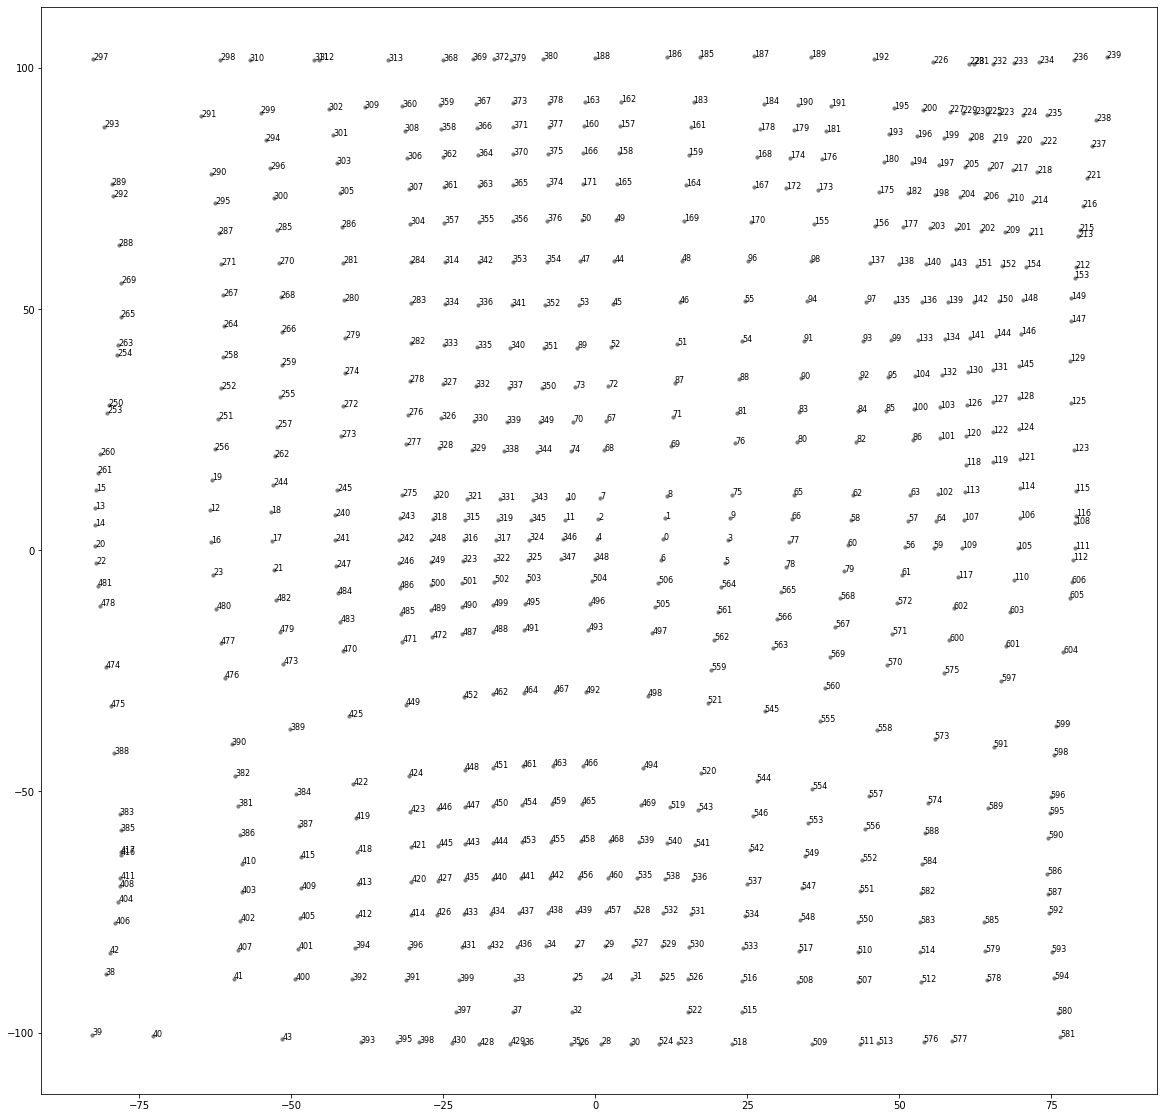

In [33]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(flat_mesh.vertices[:,0],flat_mesh.vertices[:,1],c='grey',s=10)
for i in range(flat_mesh.vertices.shape[0]):
    plt.text(flat_mesh.vertices[i,0], flat_mesh.vertices[i,1], str(i),fontsize=8)

In [34]:
from trimesh import grouping
# we know that in a watertight mesh every edge will be included twice
# thus every edge which appears only once is part of a boundary
boundary_groups = grouping.group_rows(
    flat_mesh.edges_sorted, require_count=1)

boundary_edges = flat_mesh.edges[boundary_groups]
index_as_dict = [{'index': i} for i in boundary_groups]

import networkx as nx

# we create a graph of the boundary edges, and find cycles.
g = nx.from_edgelist(
    np.column_stack((boundary_edges,
                     index_as_dict)))
idxs = []
for vertex in nx.cycle_basis(g):
    idxs.append(vertex)


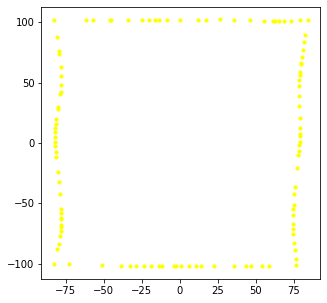

In [38]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(flat_mesh.vertices[idxs,0],flat_mesh.vertices[idxs,1],c='yellow',s=10)

In [36]:
np.array(idxs)

array([[511, 509, 518, 523, 524,  30,  28,  26,  35,  36, 429, 428, 430,
        398, 395, 393,  43,  40,  39,  38,  42, 406, 404, 408, 411, 416,
        417, 385, 383, 388, 475, 474, 478, 481,  22,  20,  14,  13,  15,
        261, 260, 253, 250, 254, 263, 265, 269, 288, 292, 289, 293, 297,
        298, 310, 311, 312, 313, 368, 369, 372, 379, 380, 188, 186, 185,
        187, 189, 192, 226, 228, 231, 232, 233, 234, 236, 239, 238, 237,
        221, 216, 215, 213, 212, 153, 149, 147, 129, 125, 123, 115, 116,
        108, 111, 112, 606, 605, 604, 599, 598, 596, 595, 590, 586, 587,
        592, 593, 594, 580, 581, 577, 576, 513]])

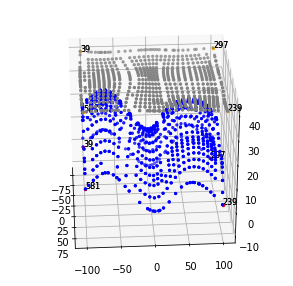

In [39]:
handles = [39, 297, 239, 581]

plt.rcParams["figure.figsize"] = (5,5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

from IPython.display import HTML
import matplotlib.animation as animation

def init():
    ax.scatter(flat_mesh.vertices[:,0],flat_mesh.vertices[:,1],flat_mesh.vertices[:,2]+40,c='grey',s=5)
    ax.scatter(curved_mesh.vertices[:,0],curved_mesh.vertices[:,1],curved_mesh.vertices[:,2],c='blue',s=5)
    for i in [*handles]:
        ax.scatter(flat_mesh.vertices[i,0],flat_mesh.vertices[i,1],flat_mesh.vertices[i,2]+40,c='orange',s=5)
        ax.text(flat_mesh.vertices[i,0], flat_mesh.vertices[i,1],flat_mesh.vertices[i,2]+40, str(i),fontsize=8)
        ax.scatter(curved_mesh.vertices[i,0],curved_mesh.vertices[i,1],curved_mesh.vertices[i,2],c='red',s=5)
        ax.text(curved_mesh.vertices[i,0],curved_mesh.vertices[i,1],curved_mesh.vertices[i,2], str(i),fontsize=8)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())